In [2]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import jaxley as jx
from jaxley.channels import HH

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import jax.numpy as jnp
from jaxley.utils.cell_utils import interpolate_xyz, loc_of_index
from copy import deepcopy

In [561]:
class DummyModule:
    def __init__(self, module):
        self.nodes = module.nodes
        self.edges = module.edges
        self.branch_edges = module.branch_edges
        self.recordings = module.recordings
        self.synapses = module.synapses
        self.synapse_param_names = module.synapse_param_names
        self.synapse_state_names = module.synapse_state_names
        self.synapse_names = module.synapse_names
        self.channels = module.channels
        self.membrane_current_names = module.membrane_current_names
        self.trainable_params = module.trainable_params
        self.indices_set_by_trainables = module.indices_set_by_trainables
        self.comb_parents = module.comb_parents
        self.externals = module.externals
        self.external_inds = module.external_inds
        self.xyzr = module.xyzr
        self.nseg = module.nseg
        self._in_view = self.nodes.index.to_numpy()
        self._scope = "global"
        self.groups = {}
        self.__class__.__name__ = module.__class__.__name__

        self._add_local_indices()
        self.view = self

    def _add_local_indices(self) -> pd.DataFrame:
        idx_cols = ["global_comp_index", "global_branch_index", "global_cell_index"]
        self.nodes.rename(columns={col.replace("global_", ""):col for col in idx_cols}, inplace=True)
        idcs = self.nodes[idx_cols]
        
        def reindex_a_by_b(df, a, b):
            df.loc[:, a] = df.groupby(b)[a].rank(method="dense").astype(int) - 1
            return df

        idcs = reindex_a_by_b(idcs, idx_cols[1], idx_cols[2])
        idcs = reindex_a_by_b(idcs, idx_cols[0], idx_cols[1:])
        idcs.columns = [col.replace("global", "local") for col in idx_cols]
        self.nodes = pd.concat([idcs, self.nodes], axis=1) 

    def _reformat_index(self, idx):
        idx = np.array([idx]) if isinstance(idx, (int, np.int64)) else idx
        idx = np.array(idx) if isinstance(idx, (list,range)) else idx
        idx = np.arange(self.nodes.index.max() + 1)[idx] if isinstance(idx, slice) else idx
        if isinstance(idx, str):
            assert idx == "all", "Only 'all' is allowed"
            idx = self.nodes.index.to_numpy() 
        assert isinstance(idx, np.ndarray), "Invalid type"
        assert idx.dtype == np.int64, "Invalid dtype"
        return idx.reshape(-1)

    def at(self, idx, sorted=False):
        idx = self._reformat_index(idx)
        new_indices = self._in_view[idx]
        new_indices = np.sort(new_indices) if sorted else new_indices
        return View(self, at=new_indices)

    def set(self, key, value):
        self.view.nodes.loc[self._in_view, key] = value

    def set_scope(self, scope):
        self._scope = scope

    def scope(self, scope):
        view = View(self)
        view.set_scope(scope)
        return view
    
    def _at_level(self, level: str, idx):
        idx = self._reformat_index(idx)
        where = self.nodes[self._scope+f"_{level}_index"].isin(idx)
        inds = np.where(where)[0]
        return self.at(inds)

    def cell(self, idx):
        return self._at_level("cell", idx)
    
    def branch(self, idx):
        return self._at_level("branch", idx)
    
    def comp(self, idx):
        return self._at_level("comp", idx)
    
    def loc(self, at: float):
        comp_edges = np.linspace(0, 1, self.view.nseg+1)
        idx = np.digitize(at, comp_edges)
        view = self.comp(idx)
        return view
        
    def add_group(self, name, inds=None):
        inds = self._in_view if inds is None else inds
        inds = self._reformat_index(inds)
        self.view.groups[name] = inds

    def __getattr__(self, key):
        if key.startswith("__"):
            return super().__getattribute__(key)

        if key in self.groups:
            return self.at(self.groups[key])
        
    def show(self):
        return self.nodes.copy() # prevents this from being edited
    
    def __getitem__(self, idx):
        levels = ["network", "cell", "branch", "comp"]
        module = self.view.__class__.__name__.lower() # 
        module = "comp" if module == "compartment" else module
        
        children = levels[levels.index(module)+1:]
        idx = idx if isinstance(idx, tuple) else (idx,)
        view = self
        for i, child in enumerate(children):
            view = view._at_level(child, idx[i])
        return view
    
    def _iter_level(self, level):
        col = self._scope + f"_{level}_index"
        idxs = self.nodes[col].unique()
        for idx in idxs:
            yield self._at_level(level, idx)
    
    @property
    def cells(self):
        yield from self._iter_level("cell")
    
    @property
    def branches(self):
        yield from self._iter_level("branch")

    @property
    def comps(self):
        yield from self._iter_level("comp")    

    @property
    def shape(self):
        cols = ["global_cell_index", "global_branch_index", "global_comp_index"]
        raw_shape = self.nodes[cols].nunique().to_list()

        # ensure (net.shape -> dim=3, cell.shape -> dim=2, branch.shape -> dim=1, comp.shape -> dim=0)
        levels = ["network", "cell", "branch", "comp"]
        module = self.view.__class__.__name__.lower()
        module = "comp" if module == "compartment" else module
        shape = tuple(raw_shape[levels.index(module):])
        return shape
    
    def copy(self, reset_index=False, as_module=False):
        view = deepcopy(self)
        # TODO: add reset_index, i.e. for parents, nodes, edges etc. such that they
        # start from 0/-1 and are contiguous
        if as_module:
            # TODO: initialize a new module with the same attributes
            pass
        return view

    # TODOs
    def vis(self, dims=[0,1], level="branch", ax=None, type="line", **kwargs):
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(3, 3))
        if level == "branch":
            for coords_of_branch in self.xyzr:
                x1, x2 = coords_of_branch[:, dims].T

                if "line" in type.lower():
                    _ = ax.plot(x1, x2, **kwargs)
                elif "scatter" in type.lower():
                    _ = ax.scatter(x1, x2, **kwargs)
                else:
                    raise NotImplementedError
        if level == "comp":
            x1, x2 = self.nodes[["x", "y", "z"]].values[:, dims].T
            ax.scatter(x1, x2, **kwargs)
        return ax


    def _append_multiple_synapses(self, pre_rows, post_rows, synapse_type):
        pass
    
    def insert(self, channel):
        pass

    def record(self, state, verbose=False):
        pass

    def stimulate(self, state, verbose=False):
        pass

    def show(self):
        with View(net, self._at) as view:
            return view.nodes
    
    def set(self, key, value):
        self.nodes.loc[:,key] = value
    
    # def _at_level(self, level: str, idx):
    #     idx = self._reformat_index(idx)
    #     with View(net, self._at) as view:
    #         where = view.nodes[f"{level}_index"].isin(idx)
    #     inds = np.where(where)[0]
    #     return self.at(inds)

    # def cell(self, idx):
    #     return self._at_level("cell", idx)
    
    # def branch(self, idx):
    #     return self._at_level("branch", idx)
    
    # def comp(self, idx):
    #     return self._at_level("comp", idx)
        
    
test_net = WrappedModule(net)

In [407]:
class WrappedModule:
    def __init__(self, module):
        self.nodes = module.nodes
        self.edges = module.edges
        self.branch_edges = module.branch_edges
        self.recordings = module.recordings
        self._in_view = self.nodes.index.to_numpy()
        self._scope = "global"

        self._add_local_indices()
        self.view = View(self)

    def _add_local_indices(self) -> pd.DataFrame:
        idx_cols = ["global_comp_index", "global_branch_index", "global_cell_index"]
        self.nodes.rename(columns={col.replace("global_", ""):col for col in idx_cols}, inplace=True)
        idcs = self.nodes[idx_cols]
        
        def reindex_a_by_b(df, a, b):
            df.loc[:, a] = df.groupby(b)[a].rank(method="dense").astype(int) - 1
            return df

        idcs = reindex_a_by_b(idcs, idx_cols[1], idx_cols[2])
        idcs = reindex_a_by_b(idcs, idx_cols[0], idx_cols[1:])
        idcs.columns = [col.replace("global", "local") for col in idx_cols]
        self.nodes = pd.concat([idcs, self.nodes], axis=1) 

    def move(self, x,y,z, update_nodes=True):
        pass

    def move_to(self, x,y,z, update_nodes=True):
        pass

    def rotate(self, degrees, rotation_axis, update_nodes=True):
        pass

class View(DummyModule):
    def __init__(self, pointer, at = None):
        # attrs with a static view
        self._scope = pointer._scope
        self.view = pointer.view
        self.initialized_morph = pointer.initialized_morph
        self.initialized_syns = pointer.initialized_syns
        self.allow_make_trainable = pointer.allow_make_trainable
        
        # attrs affected by view
        self.nseg = pointer.nseg
        self._in_view = pointer._in_view if at is None else at

        self.nodes = pointer.nodes.loc[self._in_view]
        self.branch_edges = pointer.branch_edges.loc[self._branch_edges_in_view]
        self.edges = pointer.edges.loc[self._edges_in_view]
        self.xyzr = self._xyzr_in_view(pointer)
        self.nseg = 1 if len(self.nodes) == 1 else pointer.nseg
        self.total_nbranches = len(self._branches_in_view)
        self.nbranches_per_cell = self._nbranches_per_cell_in_view()
        self.cumsum_nbranches = np.cumsum(self.nbranches_per_cell)

        self.synapses_names = self.edges["type"].unique()
        self.synapses, self.synapse_param_names, self.synapse_state_names = self._synapses_in_view(pointer)

        self.recordings = pointer.recordings.loc[pointer.recordings["rec_index"].isin(self._comps_in_view)]
        
        self.channels = self._channels_in_view(pointer)
        self.membrane_current_names = [c._name for c in self.channels]

        self.indices_set_by_trainables, self.trainable_params = self._trainables_in_view()

        self.comb_parents = self.view.comb_parents[self._branches_in_view]
        self.externals, self.external_inds = self._externals_in_view()

        #TODO:
        # self.debug_states

        if len(self.nodes) == 0:
            raise ValueError("Nothing in view. Check your indices.")
        
    def _externals_in_view(self):
        externals_in_view = {}
        external_inds_in_view = []
        for (name, inds), data in zip(self.view.external_inds.items(), self.view.externals.values()):
            in_view = np.isin(inds, self._in_view)
            inds_in_view = inds[in_view]
            if len(inds_in_view) > 0:
                externals_in_view[name] = data[in_view]
                external_inds_in_view.append(inds_in_view)
        return externals_in_view, external_inds_in_view

    def _trainables_in_view(self):
        trainable_inds = self.view.indices_set_by_trainables
        trainable_inds = np.unique(np.hstack([inds.reshape(-1) for inds in trainable_inds]))
        trainable_inds_in_view = np.intersect1d(trainable_inds, self._in_view)
        
        índices_set_by_trainables_in_view = []
        trainable_params_in_view = []
        for inds, params in zip(self.view.indices_set_by_trainables, self.view.trainable_params):
            in_view = np.isin(inds, trainable_inds_in_view)
            
            completely_in_view = in_view.all(axis=1)
            índices_set_by_trainables_in_view.append(inds[completely_in_view])
            trainable_params_in_view.append({k:v[completely_in_view] for k,v in params.items()})
            
            partially_in_view = in_view.any(axis=1) & ~completely_in_view
            índices_set_by_trainables_in_view.append(inds[partially_in_view][in_view[partially_in_view]])
            trainable_params_in_view.append({k:v[partially_in_view] for k,v in params.items()})

        índices_set_by_trainables_in_view = [inds for inds in índices_set_by_trainables_in_view if len(inds) > 0]
        trainable_params_in_view = [p for p in trainable_params_in_view if len(next(iter(p.values()))) > 0]
        return índices_set_by_trainables_in_view, trainable_params_in_view

    def _channels_in_view(self, pointer):
        names = [name._name for name in pointer.channels]
        channel_in_view = self.nodes[names].any(axis=0)
        channel_in_view = channel_in_view[channel_in_view].index
        return [c for c in pointer.channels if c._name in channel_in_view]
        
    def _synapses_in_view(self, pointer):
        viewed_synapses = []
        viewed_params = []
        viewed_states = []
        if not pointer.synapses is None:
            for syn in pointer.synapses:
                if syn is not None: # needed for recurive viewing
                    in_view = syn._name in self.synapses_names
                    viewed_synapses += [syn] if in_view else [None] # padded with None to keep indices consistent
                    viewed_params += list(syn.synapse_params.keys()) if in_view else []
                    viewed_states += list(syn.synapse_states.keys()) if in_view else []

        return viewed_synapses, viewed_params, viewed_states
        
    def _nbranches_per_cell_in_view(self):
        cell_nodes = self.nodes.groupby("global_cell_index")
        return cell_nodes["global_branch_index"].nunique().to_numpy()       

    def _xyzr_in_view(self, pointer):
        prev_branch_inds = pointer._branches_in_view
        viewed_branch_inds = self._branches_in_view
        if prev_branch_inds is None:
            xyzr = pointer.xyzr.copy() # copy to prevent editing original
        else:
            branches2keep = np.isin(prev_branch_inds, viewed_branch_inds)
            branch_inds2keep = np.where(branches2keep)[0]
            xyzr = [pointer.xyzr[i] for i in branch_inds2keep].copy()

        # Currently viewing with `.loc` will show the closest compartment
        # rather than the actual loc along the branch!
        viewed_nseg_for_branch = self.nodes.groupby("global_branch_index").size()
        incomplete_inds = np.where(viewed_nseg_for_branch != self.view.nseg)[0]
        incomplete_branch_inds = viewed_branch_inds[incomplete_inds]

        cond = self.nodes["global_branch_index"].isin(incomplete_branch_inds)
        interp_inds = self.nodes.loc[cond]
        local_inds_per_branch = interp_inds.groupby("global_branch_index")["local_comp_index"]
        locs = [loc_of_index(inds.to_numpy(), self.view.nseg) for _, inds in local_inds_per_branch]
        
        for i, loc in zip(incomplete_inds, locs):
            xyzr[i] = interpolate_xyz(loc, xyzr[i]).T
        return xyzr

    @property
    def _nodes_in_view(self):
        return self._in_view
    
    @property
    def _branch_edges_in_view(self):
        incl_branches = self.nodes["global_branch_index"].unique()
        pre = self.view.branch_edges["parent_branch_index"].isin(incl_branches)
        post = self.view.branch_edges["child_branch_index"].isin(incl_branches)
        viewed_branch_inds = self.view.branch_edges.index.to_numpy()[pre & post]
        return viewed_branch_inds
    
    @property
    def _edges_in_view(self):
        incl_comps = self.nodes["global_comp_index"].unique()
        pre = self.view.edges["global_pre_comp_index"].isin(incl_comps)
        post = self.view.edges["global_post_comp_index"].isin(incl_comps)
        viewed_edge_inds = self.view.edges.index.to_numpy()[pre & post]
        return viewed_edge_inds

    def __getattr__(self, name):
        # Delegate attribute access to the pointer if not found in View
        return getattr(self.pointer, name)
    
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        pass


# add test that asserts that every attr in view also has a corresponding attr in module
# apart from a few allowed exceptions
# this should trigger if new attrs are added to module that should potentially
# be included in view if they need to be accessed in a specific way

def test_view_attrs(module):
    exceptions = ["_scope", "_at", "view"]

    for name, attr in module.__dict__.items():
        if name not in exceptions:
            # check if attr is in view
            assert hasattr(View(module, np.array([0,1])), name), f"View missing attribute: {name}"
            # check if types match
            assert type(getattr(module, name)) == type(getattr(View(module, np.array([0,1])), name), f"Type mismatch: {name}")
            


In [20]:
from jaxley.connect import connect
from jaxley.synapses import IonotropicSynapse, TestSynapse

In [157]:
# setup
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=4)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1, 1, 2, 2])
net = jx.Network([cell]*5)
net.cell(0).insert(HH())
net.cell(1).branch(0).comp(0).record("v")
net.cell(0).branch(0).comp("all").make_trainable("HH_gK")
net.cell(0).branch(1).comp(0).make_trainable("radius")
net.cell(0).branch(2).comp(0).make_trainable("radius")
net.cell(2).branch("all").make_trainable("length")
net.cell([0,1]).make_trainable("length")
net.cell(0).branch(0).comp(0).stimulate(np.zeros((1, 10)))
net.cell(0).branch([0,1]).comp(0).clamp("v", np.ones((1, 10))*-65)
net.cell(0).branch(1).comp("all").stimulate(np.ones((1, 10)))
connect(net.cell(0).branch(0).comp(0), net.cell(1).branch(1).comp(0), IonotropicSynapse())
connect(net.cell(0).branch(0).comp(0), net.cell(0).branch(1).comp(0), TestSynapse())
cell.compute_xyz()
cell._update_nodes_with_xyz()
net.compute_xyz()
net._update_nodes_with_xyz()
net = DummyModule(net)

Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 4. Total number of trainable parameters: 4
Number of newly added trainable parameters: 1. Total number of trainable parameters: 5
Number of newly added trainable parameters: 1. Total number of trainable parameters: 6
Number of newly added trainable parameters: 7. Total number of trainable parameters: 13
Number of newly added trainable parameters: 2. Total number of trainable parameters: 15
Added 1 external_states. See `.externals` for details.
Added 2 external_states. See `.externals` for details.
Added 4 external_states. See `.externals` for details.


<Axes: >

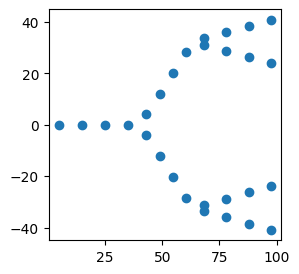

In [562]:
net.cell(0).vis(level="comp")

In [596]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from jaxley.utils.cell_utils import v_interp

def extract_outline(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    return hull_points

def compute_rotation_matrix(axis, angle):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by the given angle.
    """
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def plot_cylinder_projection(orientation, length, radius, center, dims, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # Normalize axis vector
    orientation = orientation / np.linalg.norm(orientation)
    
    # Create a rotation matrix to align the cylinder with the given axis
    z_axis = np.array([0, 0, 1])
    rotation_axis = np.cross(z_axis, orientation)
    rotation_angle = np.arccos(np.dot(z_axis, orientation))
    
    if np.allclose(rotation_axis, 0):
        rotation_matrix = np.eye(3)
    else:
        rotation_matrix = compute_rotation_matrix(rotation_axis, rotation_angle)
    
    # Define cylinder
    resolution = 100
    t = np.linspace(0, 2 * np.pi, resolution)
    z = np.linspace(-length / 2, length / 2, resolution)
    T, Z = np.meshgrid(t, z)
    
    X = radius * np.cos(T)
    Y = radius * np.sin(T)

    # Rotate cylinder
    points = np.dot(rotation_matrix, np.array([X.flatten(), Y.flatten(), Z.flatten()]))
    X = points.reshape(3,-1)
    
    # project onto plane and move
    X = X[dims]
    X += np.array(center)[dims, np.newaxis]
    
    # get outline of cylinder mesh
    X = extract_outline(X.T).T
        
    ax.fill(X[0].flatten(), X[1].flatten())
    return ax

# new vis function
def vis(view, ax=None, dims=[0,1], actual_length=False, actual_center=False):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    branches_inds = np.unique(view.view["branch_index"].to_numpy())
    for idx in branches_inds:
        locs = view.pointer.xyzr[idx][:,:3]
        if locs.shape[0] > 1:
            locs[np.isnan(locs)] = 0
            lens = np.sqrt(np.nansum(np.diff(locs, axis=0)**2, axis=1))
            lens = np.cumsum([0]+lens.tolist())
            comp_ends = v_interp(np.linspace(0,lens[-1],view.pointer.nseg+1), lens, locs).T
            comp_centers = np.array((comp_ends[1:] + comp_ends[:-1]) / 2)    
            axes = np.diff(comp_ends, axis=0)
            complens = np.sqrt(np.sum(axes**2, axis=1))

            for l, center, (i, comp), axis in zip(complens, comp_centers, view.pointer.branch(idx).view.iterrows(), axes):
                center = comp[["x", "y", "z"]] if actual_center else center
                center[np.isnan(center)] = 0
                radius = comp["radius"]
                length = comp["length"] if actual_length else l
                ax = plot_cylinder_projection(axis, length, radius, center, dims, ax)
    return ax

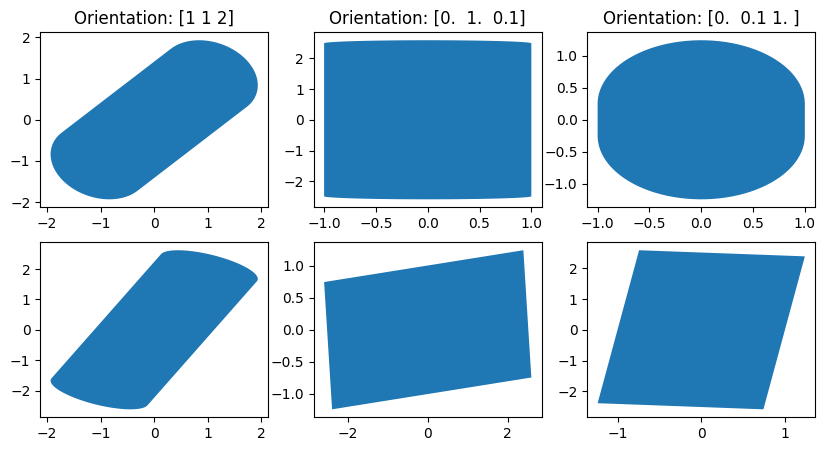

In [632]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))

for i, orientation in enumerate([np.array([1,1,2]), np.array([0,1,0.1]), np.array([0,0.1,1])]):
    plot_cylinder_projection(orientation, 5, 1, np.array([0,0,0]), dims=[0,1], ax=ax[0,i])
    plot_cylinder_projection(orientation, 5, 1, np.array([0,0,0]), dims=[1,2], ax=ax[1,i])
    ax[0,i].set_title(f"Orientation: {orientation}")
plt.show()

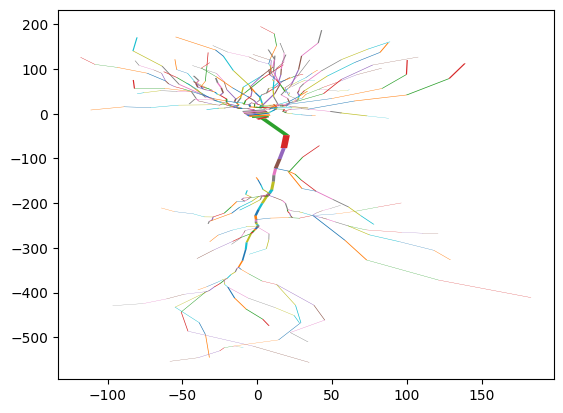

In [600]:
cell = jx.read_swc("data/morph.swc", nseg=4, max_branch_len=1000, assign_groups=True)
cell.compute_xyz()
cell._update_nodes_with_xyz()

dims = [0,1]
fig, ax = plt.subplots(1,1)
ax = vis(cell[:], ax=ax, dims=dims)
# cell.vis(ax, morph_plot_kwargs={"linewidth":0.5}, dims=dims)

<Axes: >

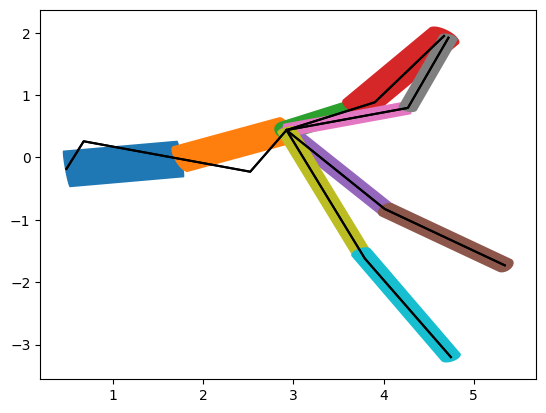

In [603]:
swc = np.loadtxt("test.swc")
np.random.seed(1)
swc[:, 2:-2] += 0.3*np.random.randn(*swc[:, 2:-2].shape)
swc[:,-2] += abs(0.02*np.random.randn(*swc[:, -2].shape))
np.savetxt("noisy_test.swc", swc)

cell = jx.read_swc("noisy_test.swc", nseg=2, max_branch_len=1000)
cell.compute_xyz()
cell._update_nodes_with_xyz()

fig, ax = plt.subplots(1,1)
dims = [0,1]
ax = vis(cell[:], ax=ax, dims=dims)
cell.vis(ax, dims=dims)
# for i,(x,y) in cell.nodes[["x", "y"]].iterrows():
#     ax.scatter(x,y, color="grey")

In [168]:
# Before: View would take a module and wrap its methods if needed. This meant:
# 1. All methods meant to be accessed both in view and module had to be hidden
#    and accessed via wrappers in either view or module. This was a lot of boilerplate.
# 2. View was fundamentally a different object from module. This meant views only
#    had access to a subset of module's methods and attributes. Hence, i.e. net.cell(0)
#    did not support looking at all its attrs and could not be simulated on its own.
# 3. Indexing global vs local and managing how things were viewed was a bit clunky.
# ----------------------------

# NEW/OLD FEATURES
# scope
net.set_scope("global")
net.cell([0,2]).branch([0]).comp([1,2]).show() # -> [1,2] 

net.set_scope("local")
net.cell([0,2]).branch([0]).comp([1,2]).show() # -> [1,2,41,42]

# context management
with net.cell(0).branch(0).comp(0) as comp0:
    comp0.set("v", -70)
    comp0.set("HH_gK", 0.1)
net.cell(0).branch(0).comp([0,1]).show()[["v", "HH_gK"]]

# iterables
for cell in net.cells:
    for branch in cell.branches:
        for comp in branch.comps:
            comp.set("v", -71)

for comp in net.cell(0).branch(0).comps:
    comp.set("v", -72)
net.show()[["v"]]

# indexing
net[0,0,0].show()

# groups
net.add_group("group1", [0,2,4])
net.cell(1).branch(0).add_group("group2")
net.group1.show()
net.group2.show()

# shape
net.shape
net.cell(0).shape

# arbitrary selection
net.set_scope("global")
net.branch(0).show()
net.comp(0).show()

# copying
cell0 = net.cell(0).copy()
cell0.show()

,local_comp_index,local_branch_index,local_cell_index,global_comp_index,global_branch_index,global_cell_index,length,radius,axial_resistivity,capacitance,...,HH_gLeak,HH_eNa,HH_eK,HH_eLeak,HH_m,HH_h,HH_n,x,y,z
0,0,0,0,0,0,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,5.000000,0.000000,0.0
1,1,0,0,1,0,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,15.000000,0.000000,0.0
2,2,0,0,2,0,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,25.000000,0.000000,0.0
3,3,0,0,3,0,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,35.000000,0.000000,0.0
4,0,1,0,4,1,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,42.940858,-4.043680,0.0
5,1,1,0,5,1,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,48.822575,-12.131041,0.0
6,2,1,0,6,1,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,54.704292,-20.218402,0.0
7,3,1,0,7,1,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,60.586009,-28.305763,0.0
8,0,2,0,8,2,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,42.940858,4.043680,0.0
9,1,2,0,9,2,0,10.0,1.0,5000.0,1.0,...,0.0003,50.0,-77.0,-54.3,0.2,0.2,0.2,48.822575,12.131041,0.0


In [115]:
net.cell([0,2]).branch([0,1,2]).comp([0,3]).set("v", 90)
net.cell(0).add_group("cell0")

# with net.cell([0,2]).branch([0,1,2]).comp([1,2]) as view:
#     view.set("v", 10)
#     view.set("capacitance", 3)

net.cell0.show()
net.cell0

net.cell([1]).channels

/home/jnsbck/Uni/PhD/projects/jaxleyverse/jaxley/jaxley/utils/cell_utils.py:299: RuntimeWarning: invalid value encountered in divide
  norm_pathlens = pathlens / pathlens[-1]  # path lengths normalized to [0,1]


[]